## PIB

In [1]:
def normalize_municipio(series):
    return series.str.replace('\-[0-9]*','').str.upper()

In [2]:
import pandas as pd

pib = pd.read_csv('madrid_towns_pib.csv', sep=';').sort_values('MUNICIPIO')
pib['MUNICIPIO'] = normalize_municipio(pib['MUNICIPIO'])
pib['HABITANTES'] = pib['HABITANTES'].apply(str).str.replace('\.','').astype(int)

pib.head()

MUNICIPIO TITULARES DECLARACIONES  HABITANTES  \
133  AGRUPACIÓN MUNICIPIOS PEQUEÑOS     8.965         7.747       17958   
61                          AJALVIR     2.412         2.155        4712   
110                       ALAMO, EL     4.685          3.99         947   
59                ALCALÁ DE HENARES   110.818         95.74      195649   
2                        ALCOBENDAS    61.878        55.393       11704   

    POSICION NACIONAL POSICION CCAA  RENTA BRUTA MEDIA  RENTA DISPONIBLE MEDIA  
133                 -             -             24.352                  20.374  
61                381            62             27.931                  22.838  
110             1.027           111             23.150                  19.622  
59                376            60             27.966                  23.012  
2                   4             3             60.842                  45.580

In [3]:
hos = pd.read_csv('madrid_towns_real_state_prices.csv', sep=';')
hos = hos.rename(columns={'Localización':'MUNICIPIO', 'Precio m2 sep 2020':'PRECIO'}).sort_values('MUNICIPIO')
hos['MUNICIPIO'] = normalize_municipio(hos['MUNICIPIO'])
hos['PRECIO'] = hos['PRECIO'].str.replace('\.', '').str.replace(' €/m2', '').astype(int)

hos.head()

MUNICIPIO  PRECIO
2  ALCALÁ DE HENARES    1774
3         ALCOBENDAS    2573
4           ALCORCÓN    2130
5   ALDEA DEL FRESNO    1029
6             ALGETE    1561

In [4]:
import numpy as np

columns = {
    'municipio_nombre': 'MUNICIPIO',
    'nuts4_nombre': 'ZONA',
    'superficie_km2': 'SUPERFICIE',
    'densidad_por_km2': 'DENSIDAD'
}

pop = pd.read_csv('madrid_towns_population.csv', sep=';', encoding='ISO-8859-1')
pop = pop[columns.keys()].rename(columns=columns).sort_values('MUNICIPIO')
pop['MUNICIPIO'] = normalize_municipio(pop['MUNICIPIO'])
pop['ZONA'] = normalize_municipio(pop['ZONA'])
pop['HABITANTES'] = (pop['SUPERFICIE'] * pop['DENSIDAD']).apply(np.round).astype(int)

pop.head()

MUNICIPIO                ZONA  SUPERFICIE  DENSIDAD  HABITANTES
0       ACEBEDA (LA)        SIERRA NORTE       21.86      3.02          66
1            AJALVIR  ESTE METROPOLITANO       19.80    225.00        4455
2  ALAMEDA DEL VALLE        SIERRA NORTE       25.70      7.74         199
3         ALAMO (EL)  SUDOESTE COMUNIDAD       22.00    415.86        9149
4  ALCALÁ DE HENARES  ESTE METROPOLITANO       88.11   2205.31      194310

## Chart

En esta grafica quiero mostrar la relacion entre la renta, el numero de habitantes, y el precio de la vivienda en la Comunidad de Madrid

MUNICIPIO  HABITANTES  RENTA BRUTA MEDIA  PRECIO    COCIENTE  \
3  ALCALÁ DE HENARES      195649             27.966  1774.0  599.024655   
4         ALCOBENDAS       11704             60.842  2573.0   35.834502   
5           ALCORCÓN      170514             27.954  2130.0  522.068040   
6   ALDEA DEL FRESNO        2838             22.688  1029.0    8.689193   
7             ALGETE       20611             39.548  1561.0   63.105343   

     COLOR  
3  #e3306b  
4  #34eb46  
5  #e3306b  
6  #34eb46  
7  #34eb46

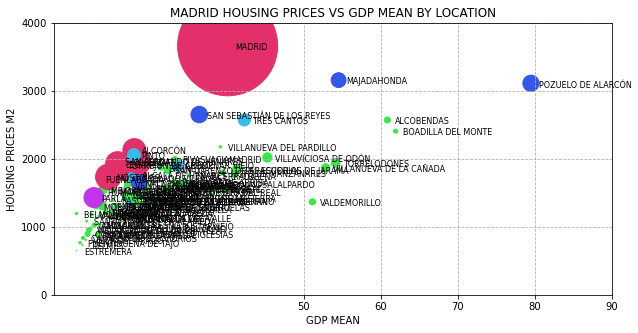

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

hosc = hos.copy()
data = (pib
    .copy()
    .loc[:, ['MUNICIPIO', 'HABITANTES', 'RENTA BRUTA MEDIA']]
    .merge(hosc, how='left', on='MUNICIPIO')
    .dropna())

def calculate_color(cociente):
    if cociente < 100:
        return '#34eb46'
    if cociente < 200:
        return '#34bdeb'
    if cociente < 300:
        return '#3357e8'
    if cociente < 400:
        return '#c334eb'
    else:
        return '#e3306b'

maxp = data['HABITANTES'].max()
data['COCIENTE'] = data['HABITANTES'].apply(lambda precio: (precio / maxp) * 10000)
data['COLOR'] = data['COCIENTE'].apply(lambda cociente: calculate_color(cociente))

data.plot.scatter(
  #  'HABITANTES', 
    'RENTA BRUTA MEDIA', 
    'PRECIO',
    ax=ax,
    yticks=np.arange(0, 5000, step=1000),
    xticks=np.arange(50, 100, step=10),
    s='COCIENTE',
    c='COLOR',
    figsize=(10, 5)
)

ax.set_title('MADRID HOUSING PRICES VS GDP MEAN BY LOCATION')
ax.set_xlabel('GDP MEAN')
ax.set_ylabel('HOUSING PRICES M2')
ax.grid(True, linestyle="dashed")

for next in range(0, len(data)):
    name, poss, cons = data.iloc[next, [0, 2, 3]]
    xpos = poss + 1
    ypos = cons - 60
    ax.text(s=name,x=xpos, y=ypos, size=8)
    
data.head()

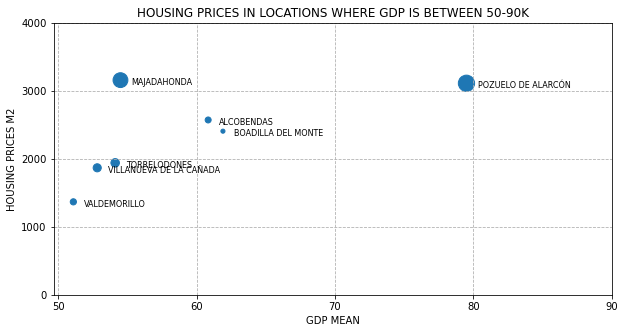

In [6]:
def set_names(data, ax, yc=0, xc=0, size=10):
    for next in range(0, len(data)):
        name, poss, cons = data.iloc[next, [0, 2, 3]]
        xpos = poss + xc
        ypos = cons + yc
        ax.text(s=name,x=xpos, y=ypos, size=size)

_, axn = plt.subplots()

data['BIN'] = pd.cut(data['RENTA BRUTA MEDIA'], bins=4, labels=range(0,4))
more_than = data.loc[data['BIN'] > 1]
more_than.plot.scatter(
    x='RENTA BRUTA MEDIA', 
    y='PRECIO', 
    ax=axn, 
    s='COCIENTE',
    yticks=np.arange(0, 5000, step=1000),
    xticks=np.arange(50, 100, step=10),
    figsize=(10, 5))

axn.set_title('HOUSING PRICES IN LOCATIONS WHERE GDP IS BETWEEN 50-90K')
axn.grid(True, linestyle="dashed")
axn.set_xlabel('GDP MEAN')
axn.set_ylabel('HOUSING PRICES M2')

set_names(more_than, axn, yc=-70, xc=0.8, size=8)

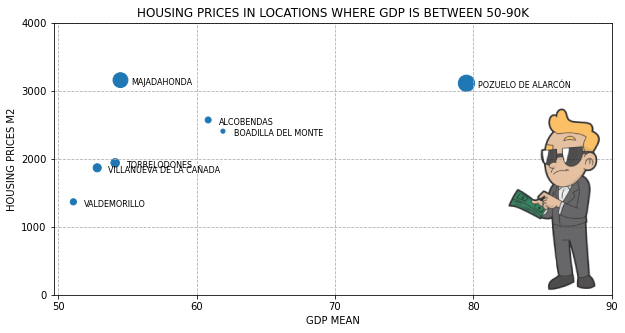

In [18]:
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

fig, axn2 = plt.subplots()

data2 = data.copy()
data2['BIN'] = pd.cut(data2['RENTA BRUTA MEDIA'], bins=4, labels=range(0,4))
more_than = data2.loc[data2['BIN'] > 1]
more_than.plot.scatter(
    x='RENTA BRUTA MEDIA', 
    y='PRECIO', 
    ax=axn2, 
    s='COCIENTE',
    yticks=np.arange(0, 5000, step=1000),
    xticks=np.arange(50, 100, step=10),
    figsize=(10, 5))

axn2.set_title('HOUSING PRICES IN LOCATIONS WHERE GDP IS BETWEEN 50-90K')
axn2.grid(True, linestyle="dashed")
axn2.set_xlabel('GDP MEAN')
axn2.set_ylabel('HOUSING PRICES M2')

set_names(more_than, axn2, yc=-70, xc=0.8, size=8)

image = mpimg.imread('rich_guy.png')
fig.figimage(image, 500, 30, zorder=0, alpha=.8)